In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#mounting drive
mount="/content/drive/"
print("Colab: mounting Google drive on ", mount)

#importing drive module from colab
from google.colab import drive

# passing mount to drive
drive.mount("/content/drive/")

# Switch to the directory on the Google Drive that we want to use
import os
drive_root = mount + "/My Drive/Colab Notebooks/Traffic_Sign_Recognition/"
  
# Create drive_root if it doesn't exist
create_drive_root = True
if create_drive_root:
  print("\nColab: making sure ", drive_root, " exists.")
  os.makedirs(drive_root, exist_ok=True)
  
# Change to the directory
print("\nColab: Changing directory to ", drive_root)
%cd $drive_root

Colab: mounting Google drive on  /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).

Colab: making sure  /content/drive//My Drive/Colab Notebooks/Traffic_Sign_Recognition/  exists.

Colab: Changing directory to  /content/drive//My Drive/Colab Notebooks/Traffic_Sign_Recognition/
/content/drive/My Drive/Colab Notebooks/Traffic_Sign_Recognition


In [ ]:
# Verify we're in the correct working directory
%pwd

'/content/drive/My Drive/Colab Notebooks/Traffic_Sign_Recognition'

In [ ]:
import os
import numpy as np 
import pandas as pd 
import cv2 as cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score

np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

Assigning Path for Dataset

In [ ]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Traffic_Sign_Recognition/"
train_path = "Train"
test_path = "Test"

#Resizing the images in 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

Finding Total Classes

In [ ]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content/drive/My Drive/Colab Notebooks/Traffic_Sign_Recognition': ['Test.csv', 'Train.csv', 'Test', 'Meta', 'Train', 'my_model.h5', 'output.index', 'Tmodel.h5', 'output.data-00001-of-00002', 'output.data-00000-of-00002', 'Tmodel', '.index', 'model.h5', '.data-00001-of-00002', '.data-00000-of-00002', 'checkpoint']


In [ ]:
#labels Overview

classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of Speed limit (180km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing vehicle over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General Caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'ENd no passing veh > 3.5 tons',}

In [ ]:
%pwd

'/content/drive/My Drive/Colab Notebooks/Traffic_Sign_Recognition'

Visualizing The Dataset

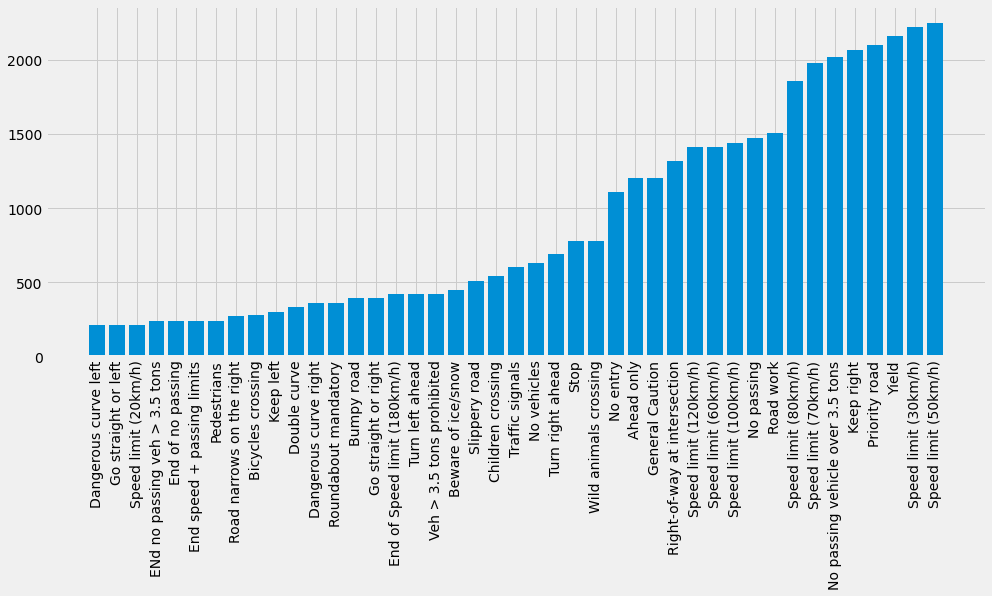

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
  train_files = os.listdir(train_path + '/' + folder)
  train_number.append(len(train_files))
  class_num.append(classes[int(folder)])

#Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

#Plotting the number of images in each class
plt.figure(figsize=(15,6))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()


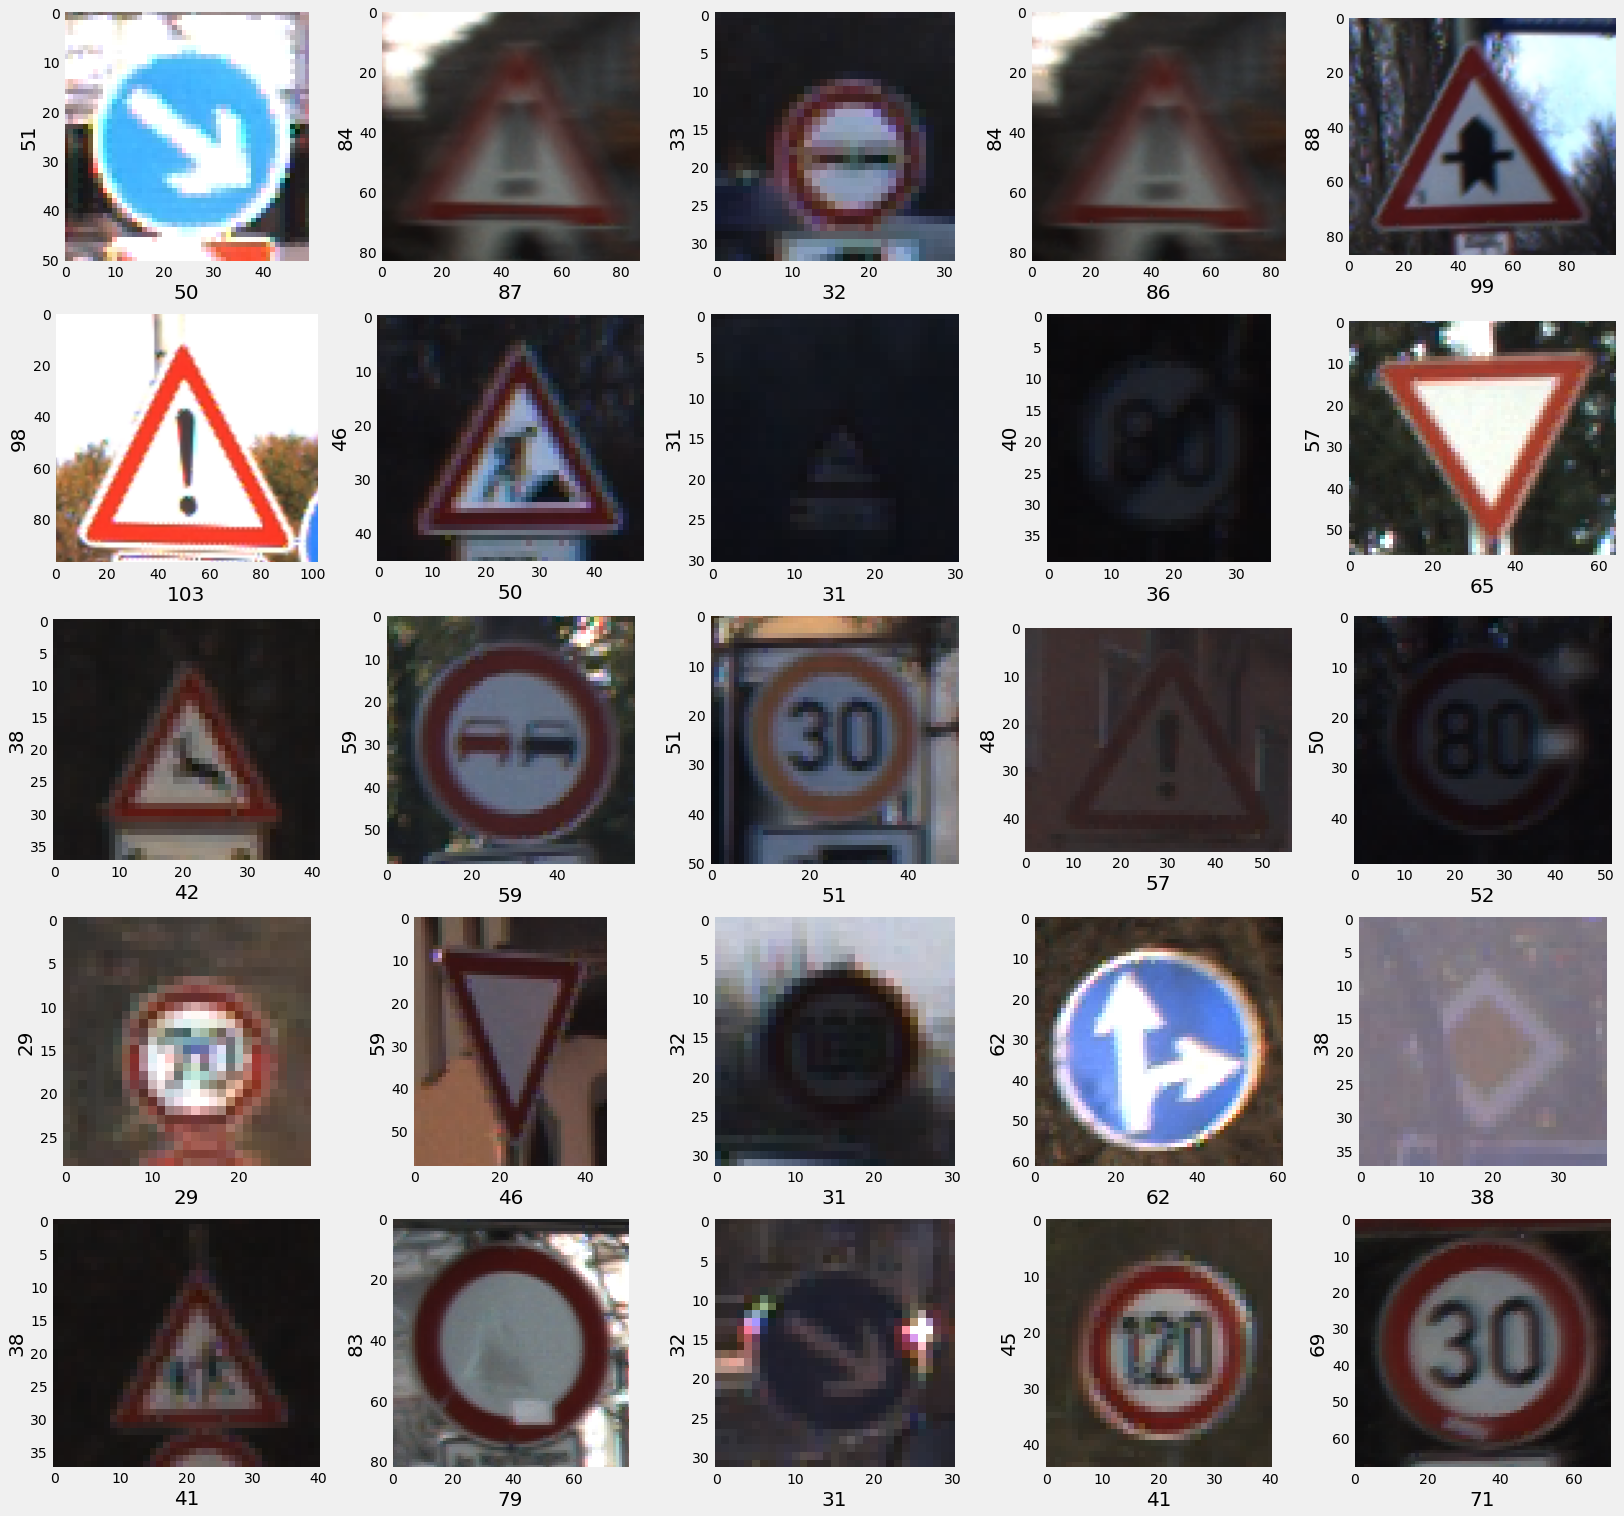

In [ ]:
#Visualizing 25 random images from test data
import random 
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range (1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20) #width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20) #height of image



In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/Traffic_Sign_Recognition'

In [ ]:
plt.hist(data_dir.ravel(),bins = 256, range = [0,256]) 
plt.show()

Collecting the Training Data

In [ ]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
      try: 
        image = cv2.imread( path + '/' + img ) #reading 
        image_fromarray = Image.fromarray(image, 'RGB') #converting into an array
        resizing_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        image_data.append(np.array(resizing_image))
        image_labels.append(i)
      except:
        print("Error in " + img)
  
#Changing the list in numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)



Error in 36
(39239, 30, 30, 3) (39239,)


Shuffling the training data

In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]


Splitting the data into train and validation set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255
  
print("X_train.shape", X_train.shape)
print("X_val.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_val.shape", y_val.shape)


X_train.shape (27467, 30, 30, 3)
X_val.shape (11772, 30, 30, 3)
y_train.shape (27467,)
y_val.shape (11772,)


One hot encoding the labels

In [ ]:
y_train = keras.utils.to_categorical (y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical (y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)


(27467, 43)
(11772, 43)


Making the model

In [ ]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),    
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
lr = 0.001 #learning rate
epochs = 30 #iterations

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Augmenting the data and training the model

In [ ]:
aug = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode = "nearest")

history = model.fit(aug.flow (X_train, y_train, batch_size = 32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
859/859 [==============================] - 20s 23ms/step - loss: 1.0876 - acc: 0.7017 - val_loss: 0.1116 - val_acc: 0.9675
Epoch 2/30
859/859 [==============================] - 17s 20ms/step - loss: 0.1880 - acc: 0.9445 - val_loss: 0.0475 - val_acc: 0.9845
Epoch 3/30
859/859 [==============================] - 18s 21ms/step - loss: 0.1122 - acc: 0.9659 - val_loss: 0.0284 - val_acc: 0.9913
Epoch 4/30
859/859 [==============================] - 24s 28ms/step - loss: 0.0812 - acc: 0.9768 - val_loss: 0.0296 - val_acc: 0.9903
Epoch 5/30
859/859 [==============================] - 17s 20ms/step - loss: 0.0695 - acc: 0.9780 - val_loss: 0.0206 - val_acc: 0.9932
Epoch 6/30
859/859 [==============================] - 17s 20ms/step - loss: 0.0604 - acc: 0.9820 - val_loss: 0.0148 - val_acc: 0.9958
Epoch 7/30
859/859 [==============================] - 17s 20ms/step - loss: 0.0471 - acc: 0.9853 - val_loss: 0.0096 - val_acc: 0.9970
Epoch 8/30
859/859 [==============================] - 17s 20ms

In [ ]:
model.save("mi_model.h5")

In [ ]:
model.save_weights("/content/drive/My Drive/Colab Notebooks/Traffic_Sign_Recognition/")

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

Evaluating the model

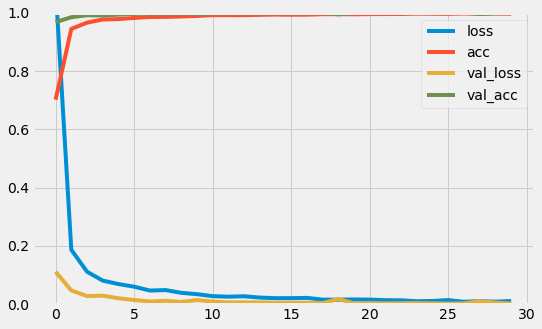

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


Loading the test data and running the predictions

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
  try:
    image = cv2.imread(data_dir + '/' + img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
    data.append(np.array(resize_image))
  except:
    print("Error in " + img)
    
X_test = np.array(data)
X_test = X_test/255

pred = model.predict_classes(X_test)


#Accuracy with the test data
print("Test Data accuracy: ", accuracy_score(labels, pred) * 100)


Test Data accuracy:  98.08392715756136


Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        60
           1       0.98      1.00      0.99       720
           2       0.99      0.99      0.99       750
           3       0.96      0.99      0.98       450
           4       1.00      0.99      1.00       660
           5       1.00      0.98      0.99       630
           6       0.99      0.99      0.99       150
           7       1.00      1.00      1.00       450
           8       1.00      1.00      1.00       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.92      0.97      0.95       420
          12       0.97      0.96      0.96       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.98      0.99      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    

Prediction on Test Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


<Figure size 1800x1800 with 0 Axes>

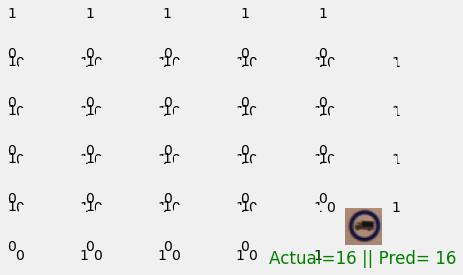

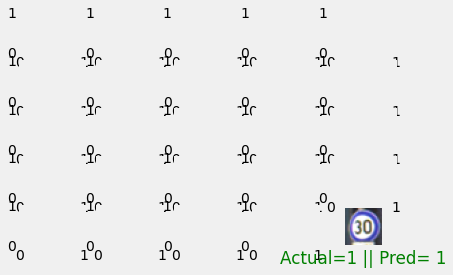

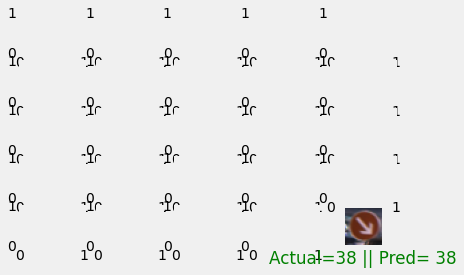

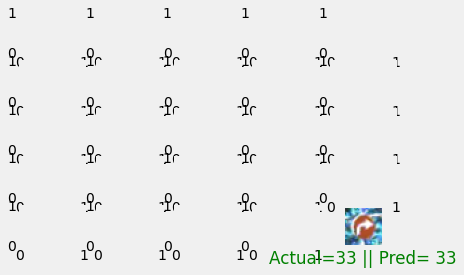

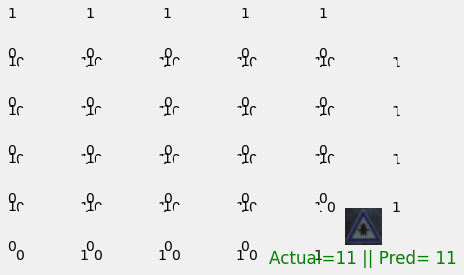

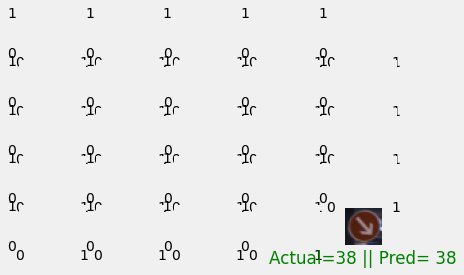

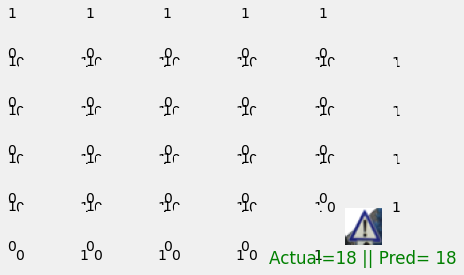

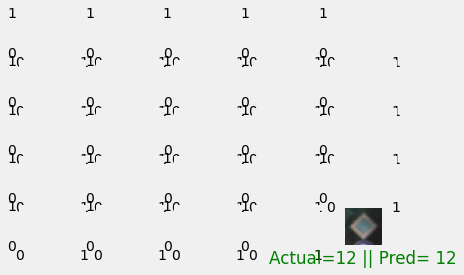

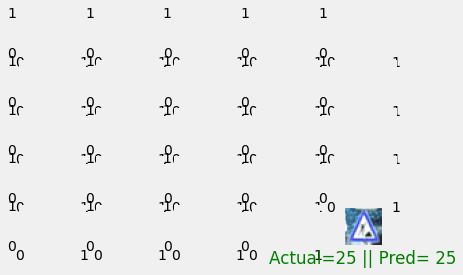

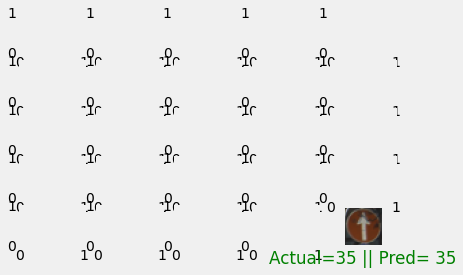

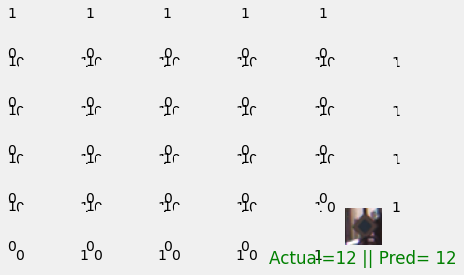

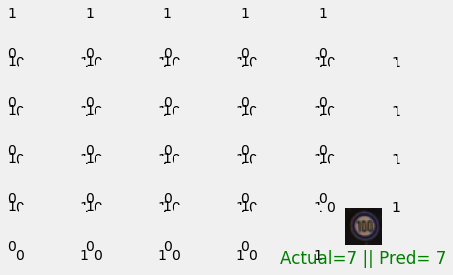

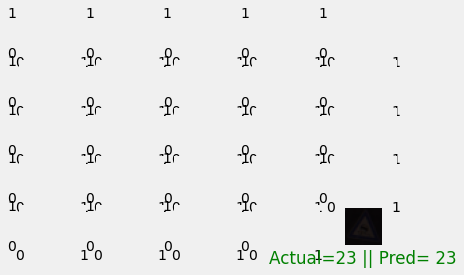

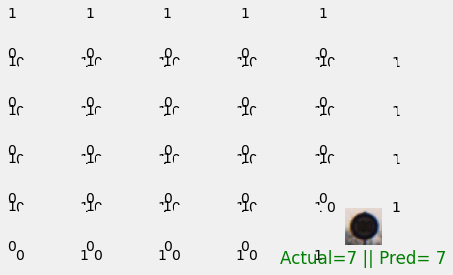

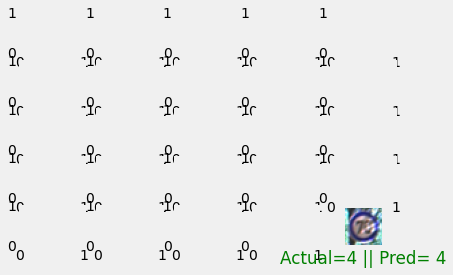

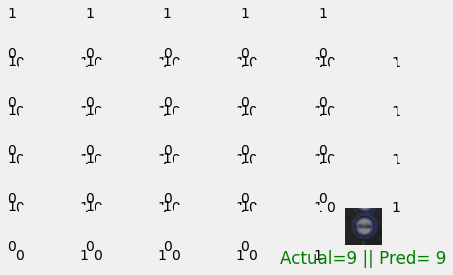

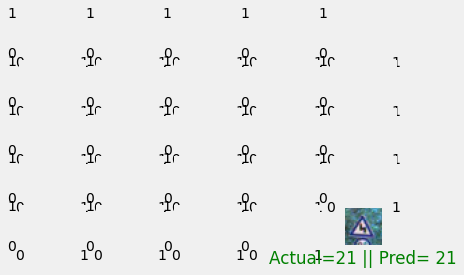

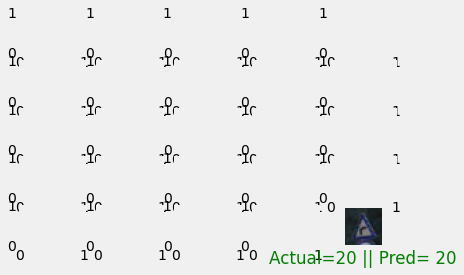

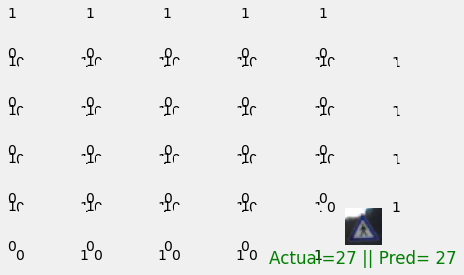

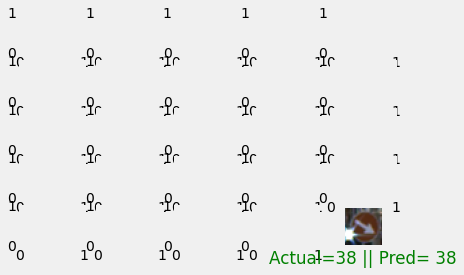

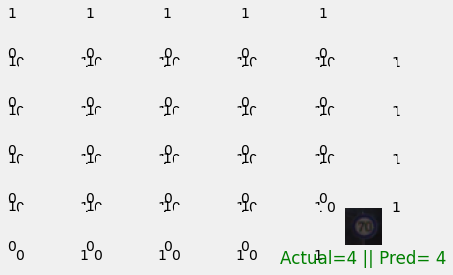

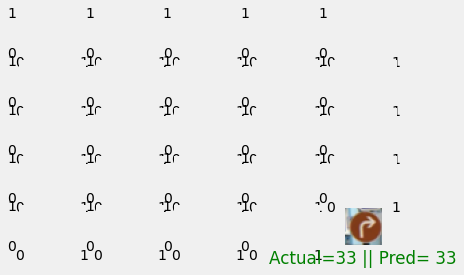

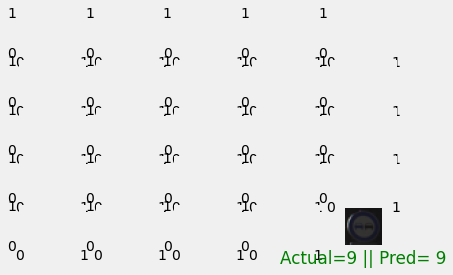

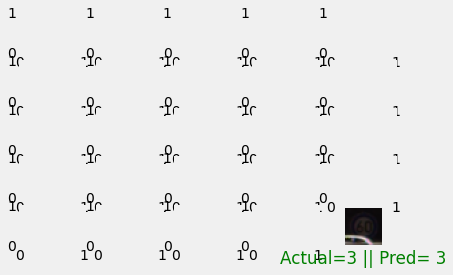

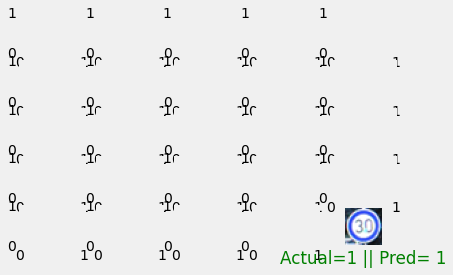

In [ ]:
plt.figure(figsize=(25 , 25))

start_index = 0
for i in range (25):
  plt.subplots(5, 5, 'none') 
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  prediction = pred[start_index + i]
  actual = labels[start_index + i]
  col = 'g'
  if prediction != actual:
    cal = 'r'
  plt.xlabel('Actual={} || Pred= {}'.format(actual,prediction), color = col)
  plt.imshow(X_test[start_index + i])

plt.show()
